## **Acesso a Energia Elétrica por Latitude**

#### Este notebook apresenta a porcentagem de domicílios sem acesso a energia elétrica em um scatter plot de latitude vs longitude e em um histograma de porcentagem por latitude.

In [1]:
from DadosAbertosBrasil import ibge
import pandas as pd
from numpy import sqrt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl

#### 1. Construir DataFrame contendo latitude, longitude e acesso a energia elétrica por distrito

In [2]:
# Coletar dados das APIs
tem = ibge.Sidra(agregado=3218, localidades={'N10':'all'}, periodos=2010, variaveis=96, classificacoes={309: 3011}).rodar()
naotem = ibge.Sidra(agregado=3218, localidades={'N10':'all'}, periodos=2010, variaveis=96, classificacoes={309: 3018}).rodar()
coor = ibge.coordenadas()

# Extrair series dos dict/json 
lista_tem = []
for distrito in tem[0]['resultados'][0]['series']:
    lista_tem.append([distrito['localidade']['id'], distrito['serie']['2010']])
    
lista_nao = []
for distrito in naotem[0]['resultados'][0]['series']:
    lista_nao.append([distrito['localidade']['id'], distrito['serie']['2010']])
    
# Montar DataFrames
df_tem = pd.DataFrame(lista_tem).rename(columns={0: 'id', 1: 'tem'}).replace({'-': 0}).astype(int).set_index('id')
df_nao = pd.DataFrame(lista_nao).rename(columns={0: 'id', 1: 'nao'}).replace({'-': 0}).astype(int).set_index('id')
df_coo = coor.loc[:, ['CD_GEOCODDS', 'NM_DISTRITO', 'LONG', 'LAT']].groupby(['CD_GEOCODDS', 'NM_DISTRITO']).mean()

df = df_tem.merge(right=df_nao, left_index=True, right_index=True).merge(right=df_coo, how='left', left_index=True, right_on='CD_GEOCODDS').reset_index()
df['total'] = df.tem.add(df.nao)
df['p'] = df.nao.divide(df.total)
display(df.sample(10))

,CD_GEOCODDS,NM_DISTRITO,tem,nao,LONG,LAT,total,p
8607,430585020,RIO BONITO,66,1,-52.809784,-28.049425,67,0.014925
8426,430220405,BOA VISTA DO BURICÁ,2218,7,-54.119793,-27.660324,2225,0.003146
9062,431460505,PIRATINI,5033,20,-53.104734,-31.444112,5053,0.003958
7762,412545605,SÃO JOSÉ DAS PALMEIRAS,1223,0,-54.059918,-24.834082,1223,0.000000
6970,355030873,BRASÍLIA,46679,13,NaN,NaN,46692,0.000278
7783,412600905,SÃO SEBASTIÃO DA AMOREIRA,2647,9,-50.762401,-23.460646,2656,0.003389
8027,420620705,GRAVATAL,3558,0,-49.030354,-28.359799,3558,0.000000
2530,260390010,IBITIRANGA,1701,32,-37.718722,-7.724291,1733,0.018465
4841,314300505,MONTE BELO,3180,3,-46.286188,-21.360108,3183,0.000943
1174,230100020,JUSTINIANO DE SERPA,2225,28,-38.494664,-4.044522,2253,0.012428


#### 2. Calcular dados do histograma

In [3]:
# Definir quantidade de bins e seus ranges
hmax = df.LAT.max()
hmin = df.LAT.min()
qt_bins = 50
hbin = (hmax - hmin)/qt_bins

# Consolidar valores dos bins
hist_valores = []
for i in range(qt_bins):
    bmax = hmax - i * hbin
    bmin = hmax - (1+i) * hbin
    dff = df.loc[(df.LAT > bmin) & (df.LAT <= bmax), :]
    hist_valores.append([(bmax+bmin)/2, dff.tem.sum(), dff.nao.sum(), dff.total.sum()])
    
# Criar DataFrame
hist = pd.DataFrame(hist_valores, columns=['lat', 'tem', 'nao', 'total'])

#### 3. Plottar gráficos

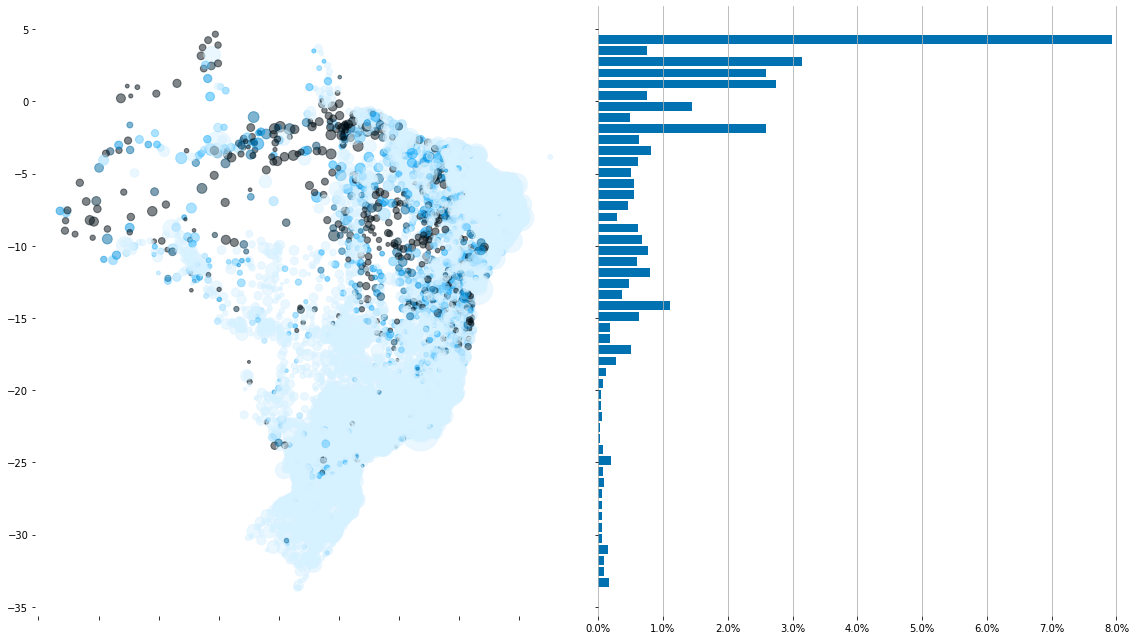

In [4]:
def color_map(x):
    if x < 0.01:
        c = '#F0E442'
    elif x < 0.02:
        c = '#33B4FF'
    elif x < 0.03:
        c = '#0072B2'
    elif x < 0.04:
        c = '#004166'
    else:
        c = '#001A29'
    return c

colors = {0.20: '#000D14',
          0.18: '#00283D',
          0.16: '#004266',
          0.14: '#006AA3',
          0.12: '#0092E0',
          0.10: '#1FB0FF',
          0.08: '#5CC6FF',
          0.06: '#99DBFF',
          0.00: '#D6F1FF'}

def colormapping(x):
    j = next(i for i in colors.keys() if x >= i)
    return colors[j]

# Remover spines
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

# Plottar gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)
ax1.scatter(df.LONG, df.LAT, c=df.p.apply(lambda x: colormapping(x)), s=df.total.apply(sqrt), alpha=0.5)
ax1.axes.xaxis.set_ticklabels([])
ax2.grid(axis='x')
ax2.barh(hist.lat, hist.nao/hist.total, height=0.8*hbin, color='#0072B2')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(5.0))
fig.tight_layout()